In [ ]:
!pip install python-igraph nilearn torch_geometric pyvis nifti2gif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 53.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.4 MB/s eta 0:00:00
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=46ca631abb1427826a4de60d4d8242a132a9135191ad7a9ea1bc34abe00e36b9
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
  Created wheel for nifti2gif: filename=nifti2gif-0.0.5-py3-none-any.whl size=7997 sha256=b32e6f4920add43b4adad4949e1858b1bf117d46075ea09cdacc73fd

In [ ]:
# Standard libraries
import os
import time
import gc
import math
import re
import warnings
from random import randint
from itertools import islice

# Image processing, computer vision, and visualization libraries
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.exposure import adjust_gamma
from skimage.future import graph
from scipy.ndimage import zoom
from scipy.spatial import cKDTree
from scipy.stats import mode
import imgaug.augmenters as iaa
from imgaug.augmentables import HeatmapsOnImage, SegmentationMapsOnImage

# Data analysis and processing
import numpy as np
import pandas as pd
import h5py
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction import image as sk_image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Augmentation libraries
import albumentations as A
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90,
    ElasticTransform, GaussNoise, RandomGamma
)
from albumentations.pytorch.transforms import ToTensorV2

# Neural Networks and Machine Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import MSELoss, Dropout
from torch.nn.parameter import Parameter
from torch.optim import Adam


# Miscellaneous
import networkx as nx
import igraph

import nibabel as nib

# Configurations
warnings.simplefilter("ignore")
scaler = MinMaxScaler()

import cv2

from skimage import data
from skimage.transform import resize
from PIL import Image, ImageOps

In [ ]:
print(torch.__version__)

2.0.1+cu118


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import torch

def get_root_dir_from_config(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            key, value = line.split('=')
            if key.strip() == 'rootdir':
                # Removing quotes
                return value.strip().replace("'", "").replace('"', '')

class GlobalConfig:
    current_working_dir = os.getcwd()
    print(current_working_dir)

    root_dir = get_root_dir_from_config('/content/gdrive/MyDrive/BRATS2020/Code/Config_file.txt')

    TrainDir = os.path.join(root_dir, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
    ValidateDir = os.path.join(root_dir, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")
    path_to_csv = os.path.join(root_dir, "train_data.csv")
    cnn_model = os.path.join(root_dir, "ResNet18")
    cnn_summary = os.path.join(root_dir, "ResNet18", "logs")
    gcn_model = os.path.join(root_dir, "GCN")
    gcn_summary = os.path.join(root_dir, "GCN", "logs")

    code = os.path.join(root_dir, "code")
    seed = 55

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)


/content


In [ ]:
import datetime

# Get current date and time
now = datetime.datetime.now()

# Format as string
now_str = now.strftime('%Y-%m-%d_%H-%M-%S')



Data preprocessing

In [ ]:

# data pre-processing time starts(dpp0)
dpp0 = time.time()

In [ ]:

survival_info_df = pd.read_csv(config.TrainDir + '/survival_info.csv')
name_mapping_df = pd.read_csv(config.TrainDir + '/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

# renaming & merging into one dataframe

In [ ]:
paths = []
for _, row  in df.iterrows():

    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    if phase == 'Training':
        path = os.path.join(config.TrainDir, id_)
    else:
        path = os.path.join(config.ValidateDir, id_)
    paths.append(path)

df['path'] = paths

In [ ]:

# Data cleaning - removing all null age entries
train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)

# Calculating Age rank for the basis of K - Fold stratification
train_data["Age_rank"] =  train_data["Age"] // 10 * 10


len(df)

369

In [ ]:
train_data

,Brats20ID,Age,Survival_days,Extent_of_Resection,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,path,Age_rank
0,BraTS20_Training_001,60.463,289,GTR,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,60.0
1,BraTS20_Training_002,52.263,616,GTR,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,50.0
2,BraTS20_Training_003,54.301,464,GTR,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,50.0
3,BraTS20_Training_004,39.068,788,GTR,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,30.0
4,BraTS20_Training_005,68.493,465,GTR,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,60.0
...,...,...,...,...,...,...,...,...,...,...,...
231,BraTS20_Training_363,57.000,62,GTR,HGG,NaN,NaN,NaN,NaN,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,50.0
232,BraTS20_Training_366,72.000,633,GTR,HGG,NaN,NaN,NaN,NaN,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,70.0
233,BraTS20_Training_367,60.000,437,STR,HGG,NaN,NaN,NaN,NaN,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,60.0
234,BraTS20_Training_368,49.000,442,GTR,HGG,NaN,NaN,NaN,NaN,/content/gdrive/MyDrive/BRATS2020/BraTS2020_Tr...,40.0


In [ ]:

# stratified k-fold ( skf ) time starts
skf0 = time.time()

In [ ]:
skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)

# enumeratng all entries for defining the fold number
# assigning the fold number in increment order
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

In [ ]:
# total stratification time(skft)
skf1 = time.time()
skft = skf1 - skf0
print("Stratification time : ",skft )

Stratification time :  1.299001693725586


In [ ]:
# splitting of the data wasn't done for train , test &  validation data
train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

# selecting the rows where the AGE col. is null --> test_df
test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)

train_df -> (202, 12) val_df -> (34, 12) test_df -> (133, 10)


In [ ]:
def plot_dataset_distribution(train_df, val_df, test_df):
    # Get the sizes
    sizes = [len(train_df), len(val_df), len(test_df)]

    # Define labels
    labels = ['Train', 'Validation', 'Test']

    # Plot
    plt.figure(figsize=(10, 7))
    plt.bar(labels, sizes, color=['blue', 'green', 'red'])

    # Annotate each bar with the exact number
    for i, v in enumerate(sizes):
        plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

    plt.title('Distribution of Data')
    plt.ylabel('Number of Samples')
    plt.show()




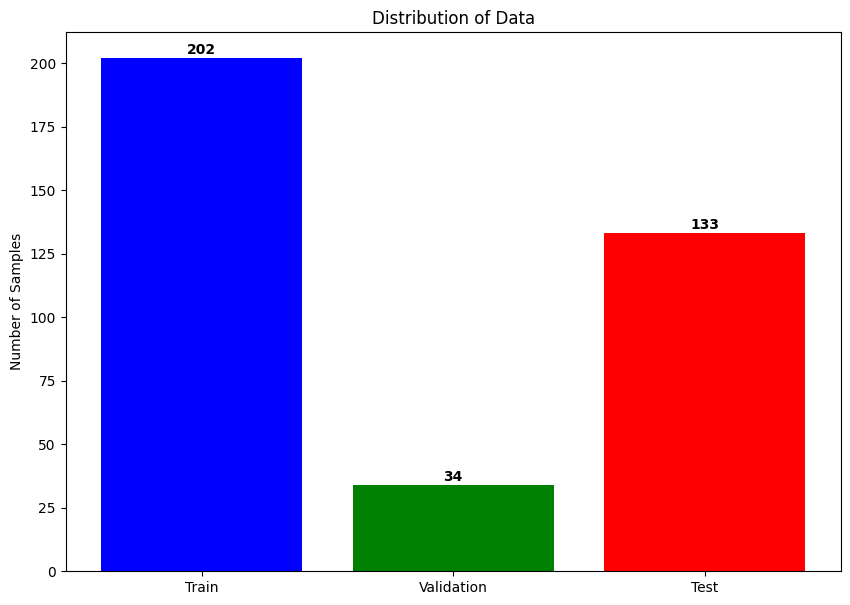

In [ ]:
# Now call the function
plot_dataset_distribution(train_df, val_df, test_df)

In [ ]:
# total data pre-processing time(dppt)
dpp1 = time.time()
dppt = dpp1 - dpp0 - skft
print("Data preprocessing time : ", dppt  )

Data preprocessing time :  7.648898363113403


In [ ]:
train_data.to_csv(config.root_dir + "train_data.csv", index=False)
test_df.to_csv(config.root_dir +"validation_df.csv", index=False)
train_df.to_csv(config.root_dir +"train_df.csv", index=False)

In [ ]:
from torch.utils.data import Dataset

class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=True):
        """
        Initialize the BratsDataset.

        Parameters:
        - df (pd.DataFrame): The dataframe containing the dataset information.
        - phase (str): Phase the data is being used for - can be 'train', 'validate', or 'test'. Default is 'test'.
        - is_resize (bool): Whether to resize the images. Default is True.
        """
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii']
        self.is_resize = is_resize

    def __len__(self):
        """
        Get the total number of items in the dataset.

        Returns:
        int: Total number of items.
        """
        return self.df.shape[0]

    def __getitem__(self, idx):
        """
        Fetch a single item from the dataset given its index.

        Parameters:
        - idx (int): The index of the desired item.

        Returns:
        dict: Contains the ID, image and optionally the mask (if phase isn't 'test').
        """
        # at a specified index ( idx ) select the value under 'Brats20ID' & asssign it to id_
        id_ = self.df.loc[idx, 'Brats20ID']

        # As we've got the id_ , now find the path of the entry by asserting the Brats20ID to id_
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]

        # load all modalities
        images = []

        for data_type in self.data_types:
            # here data_type is appended to the root path, as it only contains the name without the datatype such as .nii etc
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)

            if self.is_resize:
                img = self.resize(img)

            img = self.normalize(img)

        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)


            if self.is_resize:
                mask = self.resize(mask)
                # mask --> conversion to uint8 --> normalization / clipping ( 0 to 1 ) --> conversion to float32
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                # again clipping ( 0 to 1 )
                mask = np.clip(mask, 0, 1)

            # setting the mask labels 1 , 2 , 4 for the mask file ( _seg.ii )
            mask = self.preprocess_mask_labels(mask)

            augmented = self.augmentations(image=img.astype(np.float32),
                                           mask=mask.astype(np.float32))
            # Several augmentations / transformations like flipping, rotating, padding will be applied to both the images
            img = augmented['image']
            mask = augmented['mask']


            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }

        return {
            "Id": id_,
            "image": img,
        }

    def load_img(self, file_path):
        """
        Load an image given its path.

        Parameters:
        - file_path (str): Path to the image.

        Returns:
        np.ndarray: Loaded image data.
        """
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    def normalize(self, data: np.ndarray):
        """
        Normalize a given image.

        Parameters:
        - data (np.ndarray): The image data.

        Returns:
        np.ndarray: The normalized image.
        """
        data_min = np.min(data)
        # normalization = (each element - min element) / ( max - min )
        return (data - data_min) / (np.max(data) - data_min)

    def resize(self, data: np.ndarray):
        """
        Resize an image.

        Parameters:
        - data (np.ndarray): The image data.

        Returns:
        np.ndarray: The resized image.
        """
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data

    def preprocess_mask_labels(self, mask: np.ndarray):
        """
        Preprocess mask labels.

        This function currently sets mask labels 1, 2, and 4 to 1,
        effectively making it a binary mask.

        Parameters:
        - mask (np.ndarray): The original mask data.

        Returns:
        np.ndarray: The preprocessed mask.
        """
        # whole tumour
        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1
        return mask

In [ ]:
def get_augmentations(phase):
    """
    Constructs a composed list of transformations for the given phase.

    Parameters:
    - phase (str): The phase of the process (e.g., 'train', 'test') to determine which set of transformations to return.

    Returns:
    - Compose: A composition of transformations.
    """
    list_transforms = []
    list_trfms = Compose(list_transforms)
    return list_trfms



def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4 ):
    """
    Returns a DataLoader object for the given dataset and phase.

    Parameters:
    - dataset (torch.utils.data.Dataset): The type of dataset to be used.
    - path_to_csv (str): Path to the CSV file containing the dataset details.
    - phase (str): The phase of the process ('train' or 'valid').
    - fold (int, optional): The fold index for cross-validation. Default is 0.
    - batch_size (int, optional): Number of samples per batch. Default is 1.
    - num_workers (int, optional): Number of subprocesses to use for data loading. Default is 4.

    Returns:
    - DataLoader: DataLoader object for the given dataset and phase.
    """

    df = pd.read_csv(path_to_csv)
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    if phase == "train" :
        df = train_df
    elif phase == "valid" :
        df = val_df

    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [ ]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv= config.root_dir+'train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [ ]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_164'],
 torch.Size([1, 78, 120, 120]),
 torch.Size([1, 78, 120, 120]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_func(data):
    # Extract the first Image
    print(f"{data['Id']} : image shape: {data['image'].shape} , mask shape:{data['mask'].shape}")
    batch = data

    img_tensor = batch['image'].squeeze().cpu().detach().numpy()
    mask_tensor = batch['mask'].squeeze().cpu().detach().numpy()

    print(img_tensor.shape)

    print("Num uniq Image values:", len(np.unique(img_tensor, return_counts=True)[0]))
    print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
    print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

    # Select the middle slice
    middle_slice = img_tensor.shape[0] // 2
    image = img_tensor[middle_slice]
    mask = mask_tensor[middle_slice]


    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Original Image
    ax[0].imshow(image, cmap='bone')
    ax[0].set_title('Original Image')

    # Mask
    ax[1].imshow(mask)
    ax[1].set_title('Mask')

    # Superimposed version
    ax[2].imshow(image, cmap='bone')
    ax[2].imshow(np.ma.masked_where(mask == 0, mask), cmap='cool', alpha=0.6)
    ax[2].set_title('Superimposed')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# display_func(data)